In [ ]:
import os
import pandas as pd
import torch
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from tqdm import tqdm
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import sys

# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# model_checkpoint = "google/vit-base-patch16-224-in21k"
model_checkpoint = "agent593/Thyroid-Ultrasound-Image-Classification-ViTModel"

In [ ]:
from transformers import AutoImageProcessor, AutoFeatureExtractor, ViTForImageClassification

/opt/conda/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

In [ ]:
image_processor = AutoFeatureExtractor.from_pretrained(model_checkpoint)

/opt/conda/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [ ]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
train_transforms = Compose(
    [
        RandomResizedCrop(image_processor.size["height"]),
        RandomHorizontalFlip(),
        ToTensor(),
        normalize,
    ]
)

val_transforms = Compose(
    [
        Resize(image_processor.size["height"]),
        CenterCrop(image_processor.size["height"]),
        ToTensor(),
        normalize,
    ]
)

In [ ]:
# Define Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, root_dir, sub_folder, transform=None, data_type='original'):
        self.root_dir = root_dir
        self.sub_folder = sub_folder
        self.transform = transform
        self.data_type = data_type
        self.image_paths = []
        self.labels = []

        if self.data_type == 'original':
            self.load_original_data()
        elif self.data_type == 'augmentation':
            self.load_augmented_data()

    def load_original_data(self):
        label_file = os.path.join(self.root_dir, 'shortaxis_binary v2.xlsx')
        for video_folder in os.listdir(os.path.join(self.root_dir, self.sub_folder)):
            video_path = os.path.join(self.root_dir, self.sub_folder, video_folder)
            if os.path.isdir(video_path):
                try:
                    labels_df = pd.read_excel(label_file, sheet_name=video_folder)
                except ValueError:
                    continue

                for img_filename in os.listdir(video_path):
                    if img_filename.endswith(".jpg"):
                        img_path = os.path.join(video_path, img_filename)
                        frame_idx = int(os.path.splitext(img_filename)[0].split('_')[-1])
                        labels = labels_df.loc[frame_idx, ['BAD QUALITY', 'CORD', 'FLUID']].values.astype('float32')
                        self.image_paths.append(img_path)
                        self.labels.append(labels)

    def load_augmented_data(self):
        for video_folder in os.listdir(os.path.join(self.root_dir, self.sub_folder)):
            video_path = os.path.join(self.root_dir, self.sub_folder, video_folder)
            if os.path.isdir(video_path):
                label_file = os.path.join(self.root_dir, 'Label', f'{video_folder}.xlsx')
                labels_df = pd.read_excel(label_file)

                for img_filename in os.listdir(video_path):
                    if img_filename.endswith(".jpg"):
                        img_path = os.path.join(video_path, img_filename)
                        labels = labels_df.loc[labels_df['FILENAME'] == img_filename,
                                               ['BAD QUALITY', 'CORD', 'FLUID']].values.astype('float32')
                        self.image_paths.append(img_path)
                        self.labels.append(labels)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        labels = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, labels

In [ ]:
import pandas as pd
import os
from torch.utils.data import Dataset
from PIL import Image
import torch

In [ ]:
class DataFrameDataset(Dataset):
    def __init__(self, dataframe_path, transform=None):
        # Load the DataFrame from the given path
        self.dataframe = pd.read_csv(dataframe_path)  # Ensure your DataFrame is saved as a CSV
        self.transform = transform

        # Initialize image paths and labels from the DataFrame
        self.image_paths = self.dataframe['FILENAME'].values
        self.labels = self.dataframe[['BAD QUALITY', 'CORD', 'FLUID']].values.astype('float32')

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Get the image path and labels for the given index
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        labels = torch.tensor(self.labels[idx], dtype=torch.float32)

        # Apply any transformations if provided
        if self.transform:
            image = self.transform(image)

        return image, labels

In [ ]:
# df2 = pd.read_csv('Data Files/new_image_labels.csv')
# new_fnames = []
# for i in range(df2.shape[0]):
#     new_fnames.append('./Data Files/'+'/'.join(df2['FILENAME'][i].split("/")[4:]))
# df2['FILENAME'] = new_fnames
# df2.to_csv('./Data Files/new_image_labels_gcp.csv', index=False)

In [ ]:
root_dir = 'Data Files'    # CHANGE BASED ON FOLDER LOCATION
sub_folder = 'short axis frames'
num_classes=3
dataframe_path = './Data Files/new_image_labels_gcp.csv'  # Update the path


original_dataset = CustomDataset(root_dir, sub_folder=sub_folder, transform=None, data_type='original')
new_dataset = DataFrameDataset(dataframe_path=dataframe_path, transform=None)

In [ ]:
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
from PIL import Image
import torch

class CombinedDataset(Dataset):
    def __init__(self, original_dataset, new_dataset, transform=None):
        self.original_dataset = original_dataset
        self.new_dataset = new_dataset
        self.image_paths = original_dataset.image_paths + list(new_dataset.image_paths)
        self.labels = original_dataset.labels + list(new_dataset.labels)

        # Store information about whether an image belongs to the old or new dataset
        self.dataset_source = ['original'] * len(original_dataset.image_paths) + ['new'] * len(new_dataset.image_paths)

        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        labels = torch.tensor(self.labels[idx], dtype=torch.float32)

        if self.transform:
            image = self.transform(image)
        return image, labels, self.dataset_source[idx]

    def get_mixture_info(self, indices):
        """Returns the proportion of images from original and new datasets in a given subset."""
        subset_sources = [self.dataset_source[i] for i in indices]
        original_count = subset_sources.count('original')
        new_count = subset_sources.count('new')
        total_count = len(subset_sources)

        return {
            'original': original_count / total_count,
            'new': new_count / total_count
        }


In [ ]:
# Initialize the combined dataset
combined_dataset = CombinedDataset(original_dataset, new_dataset)

# Shuffle and split into train, validation, and test sets
indices = list(range(len(combined_dataset)))
train_indices, temp_indices = train_test_split(indices, test_size=0.2, random_state=42)
val_indices, test_indices = train_test_split(temp_indices, test_size=0.25, random_state=42)

# Create subsets for train, val, and test
train_dataset = Subset(combined_dataset, train_indices)
val_dataset = Subset(combined_dataset, val_indices)
test_dataset = Subset(combined_dataset, test_indices)

# Apply transforms
train_dataset.dataset.transform = train_transforms
val_dataset.dataset.transform = val_transforms
test_dataset.dataset.transform = val_transforms

# Print dataset sizes
print(f'Train Size: {len(train_dataset)}, Val Size: {len(val_dataset)}, Test Size: {len(test_dataset)}')

# Check the mixture info for train, validation, and test sets
train_mixture = combined_dataset.get_mixture_info(train_indices)
val_mixture = combined_dataset.get_mixture_info(val_indices)
test_mixture = combined_dataset.get_mixture_info(test_indices)

print(f"Train Mixture: {train_mixture}")
print(f"Validation Mixture: {val_mixture}")
print(f"Test Mixture: {test_mixture}")

# Example: Initialize data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Train Size: 3256, Val Size: 611, Test Size: 204
Train Mixture: {'original': 0.8258599508599509, 'new': 0.17414004914004913}
Validation Mixture: {'original': 0.855973813420622, 'new': 0.14402618657937807}
Test Mixture: {'original': 0.8725490196078431, 'new': 0.12745098039215685}


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
# Assuming your labels are: ['BAD QUALITY', 'CORD', 'FLUID']
labels = ['BAD QUALITY', 'CORD', 'FLUID']

# Creating label-to-ID and ID-to-label mappings
label2id = {label: idx for idx, label in enumerate(labels)}
id2label = {idx: label for idx, label in enumerate(labels)}

# Checking the value for ID 2
print(id2label[2])  # Output: 'FLUID'

FLUID


In [ ]:
# model = ViTForImageClassification.from_pretrained('facebook/deit-base-patch16-224',
#                                                   label2id=label2id,
#                                                   id2label=id2label,
#                                                   ignore_mismatched_sizes=True)

from transformers import AutoModelForImageClassification

model = ViTForImageClassification.from_pretrained(model_checkpoint,
                                                       label2id=label2id,
                                                       id2label=id2label,
                                                       ignore_mismatched_sizes=True)

In [ ]:
# !pip install transformers accelerate evaluate datasets peft -q

In [ ]:
def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param:.2f}"
    )

In [ ]:
print_trainable_parameters(model)

trainable params: 85800963 || all params: 85800963 || trainable%: 100.00


In [ ]:
import re
# def extract_target_layers(model):
#     """
#     Extracts layers matching attention blocks like:
#     'encoder.layer.X.attention.attention.query',
#     'encoder.layer.X.attention.attention.key',
#     'encoder.layer.X.attention.attention.value'
#     """
#     # Adjust the pattern based on actual printed names
#     pattern = re.compile(r'vit\.encoder\.layer\.\d+\.attention\.attention\.(query|key|value)')

#     # Extract matching layers
#     target_layers = [name for name, _ in model.named_parameters() if pattern.search(name)]

#     return target_layers

# # Extract the target layers
# target_layers = extract_target_layers(model)
# print(target_layers)

def extract_target_layers(model):
    """
    Extracts layer names matching the pattern:
    'vit.encoder.layer.X.attention.attention.query'
    'vit.encoder.layer.X.attention.attention.key'
    'vit.encoder.layer.X.attention.attention.value'
    without the '.weight' or '.bias' suffixes.
    """
    # Define the regex pattern to match only the base layer names
    pattern = re.compile(r'(vit\.encoder\.layer\.\d+\.attention\.attention\.(query|key|value))')

    # Use a set to avoid duplicates
    target_layers = set()

    # Extract matching layers from model parameters
    for name, _ in model.named_parameters():
        match = pattern.match(name)
        if match:
            # Add only the base layer name (without '.weight' or '.bias')
            target_layers.add(match.group(1))

    # Convert set to list and return
    return list(target_layers)

# Extract the target layers
target_layers = extract_target_layers(model)

# Print the extracted layers
print(target_layers)

['vit.encoder.layer.6.attention.attention.key', 'vit.encoder.layer.2.attention.attention.value', 'vit.encoder.layer.4.attention.attention.key', 'vit.encoder.layer.5.attention.attention.value', 'vit.encoder.layer.8.attention.attention.value', 'vit.encoder.layer.7.attention.attention.query', 'vit.encoder.layer.8.attention.attention.query', 'vit.encoder.layer.1.attention.attention.key', 'vit.encoder.layer.10.attention.attention.query', 'vit.encoder.layer.0.attention.attention.key', 'vit.encoder.layer.9.attention.attention.query', 'vit.encoder.layer.3.attention.attention.value', 'vit.encoder.layer.1.attention.attention.value', 'vit.encoder.layer.0.attention.attention.value', 'vit.encoder.layer.4.attention.attention.value', 'vit.encoder.layer.2.attention.attention.key', 'vit.encoder.layer.9.attention.attention.key', 'vit.encoder.layer.5.attention.attention.query', 'vit.encoder.layer.5.attention.attention.key', 'vit.encoder.layer.10.attention.attention.key', 'vit.encoder.layer.0.attention.at

In [ ]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=32,
    lora_alpha=32,
    target_modules = target_layers,
    lora_dropout=0.1,
    bias="none",
    modules_to_save=["classifier"],
)
lora_model = get_peft_model(model, config)
print_trainable_parameters(lora_model)

trainable params: 1771779 || all params: 87572742 || trainable%: 2.02


In [ ]:
for name, module in model.named_modules():
    print(name, ":", module)

 : ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): lora.Linear(
                (base_layer): Linear(in_features=768, out_features=768, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=768, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=768, bias=False)
                )
                (lora_embedding_A): ParameterDict()
  

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, hamming_loss, jaccard_score

def compute_metrics(eval_pred, threshold=0.5):
    predictions, references = eval_pred

    # Apply sigmoid if necessary
    predictions = 1 / (1 + np.exp(-predictions)) if predictions.ndim > 1 else predictions

    # Binarize predictions
    predictions = (predictions >= threshold).astype(int)
    references = (references >= 0.5).astype(int)  # Assuming references are probabilities

    # Compute metrics
    accuracy = accuracy_score(references, predictions)
    f1_macro = f1_score(references, predictions, average='macro')
    f1_micro = f1_score(references, predictions, average='micro')
    f1_samples = f1_score(references, predictions, average='samples')
    hamming = hamming_loss(references, predictions)
    jaccard = jaccard_score(references, predictions, average='macro')

    return {
        "accuracy": accuracy,
        "f1_macro": f1_macro,
        "f1_micro": f1_micro,
        "f1_samples": f1_samples,
        "hamming_loss": hamming,
        "jaccard": jaccard,
    }

In [ ]:
import torch

def collate_fn(examples):
    # Unpack the tuples into separate lists
    pixel_values = torch.stack([example[0] for example in examples])

    # Directly convert labels to a tensor with specified dtype
    labels = torch.stack([torch.tensor(example[1], dtype=torch.float32) for example in examples])

    return {"pixel_values": pixel_values, "labels": labels}

In [ ]:
from transformers import TrainingArguments, Trainer
from torch.nn import BCEWithLogitsLoss


class MultiLabelTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")  # Extract labels from inputs
        outputs = model(**inputs)
        logits = outputs.logits
        loss = BCEWithLogitsLoss()(logits, labels)  # Use multi-label loss
        return (loss, outputs) if return_outputs else loss

In [ ]:
import os
import logging

# Enable logging and tqdm
logging.basicConfig(level=logging.INFO)
from transformers.utils import logging as hf_logging
hf_logging.set_verbosity_info()

# Ensure the model is loaded on the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

model_name = model_checkpoint.split("/")[-1]
batch_size = 128

args = TrainingArguments(
    f"{model_name}-finetuned-lora-usg-new",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-3,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    fp16=torch.cuda.is_available(),
    num_train_epochs=30,
    logging_steps=5,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
    label_names=["labels"],
    disable_tqdm=False,  # Ensure tqdm is enabled
)

# trainer = Trainer(
#     lora_model,
#     args,
#     train_dataset=train_dataset,
#     eval_dataset=val_dataset,
#     tokenizer=image_processor,
#     compute_metrics=compute_metrics,
#     data_collator=collate_fn,
# )

trainer = MultiLabelTrainer(
    model=lora_model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)


/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/var/tmp/ipykernel_14056/1276112324.py:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `MultiLabelTrainer.__init__`. Use `processing_class` instead.
  trainer = MultiLabelTrainer(
Using auto half precision backend


In [ ]:
import wandb

# Initialize wandb
wandb.init(
    project="vit-base-finetuning-usg-pretrained-all",
    group="Base",
    name=f"{model_checkpoint}-run-{wandb.util.generate_id()}-1",
    config=args
)

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ab5640 (ab5640-columbia-university). Use `wandb login --relogin` to force relogin


In [ ]:
train_results = trainer.train()

***** Running training *****
  Num examples = 3,256
  Num Epochs = 30
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 512
  Gradient Accumulation steps = 4
  Total optimization steps = 180
  Number of trainable parameters = 1,771,779
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
/var/tmp/ipykernel_14056/2800276108.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.stack([torch.tensor(example[1], dtype=torch.float32) for example in examples])


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Micro,F1 Samples,Hamming Loss,Jaccard,Runtime,Samples Per Second,Steps Per Second
0,0.540900,0.374992,0.626841,0.534098,0.786859,0.740862,0.145117,0.453169,6.683200,91.423000,0.748000
2,0.277500,0.175179,0.806874,0.842539,0.893487,0.815603,0.075832,0.739363,5.812000,105.127000,0.860000
4,0.064500,0.049986,0.963993,0.969240,0.978723,0.867976,0.015276,0.940732,5.869500,104.098000,0.852000
6,0.034100,0.039574,0.975450,0.976316,0.983232,0.870704,0.012002,0.953986,5.778900,105.730000,0.865000
8,0.038800,0.035599,0.972177,0.973876,0.982563,0.870977,0.012548,0.949460,5.788700,105.551000,0.864000
10,0.010400,0.028330,0.978723,0.975976,0.984030,0.875887,0.011457,0.953352,5.814000,105.091000,0.860000
12,0.007700,0.024847,0.983633,0.988136,0.990854,0.878887,0.006547,0.976582,5.776400,105.776000,0.866000
14,0.003500,0.018899,0.988543,0.989232,0.993125,0.877796,0.004910,0.978754,5.728600,106.657000,0.873000
16,0.002600,0.016195,0.988543,0.987146,0.991622,0.878887,0.006001,0.974717,5.779600,105.718000,0.865000
18,0.002400,0.019012,0.988543,0.985470,0.991622,0.877796,0.006001,0.971559,5.762400,106.032000,0.868000



***** Running Evaluation *****
  Num examples = 611
  Batch size = 128
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Saving model checkpoint to Thyroid-Ultrasound-Image-Classification-ViTModel-finetuned-lora-usg-new/checkpoint-6
Image processor saved in Thyroid-Ultrasound-Image-Classification-ViTModel-finetuned-lora-usg-new/checkpoint-6/preprocessor_config.json
/var/tmp/ipykernel_14056/2800276108.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.stack([torch.tensor(example[1], dtype=torch.float32) for example in examples])

***** Running Evaluati

Saving model checkpoint to Thyroid-Ultrasound-Image-Classification-ViTModel-finetuned-lora-usg-new/checkpoint-58
Image processor saved in Thyroid-Ultrasound-Image-Classification-ViTModel-finetuned-lora-usg-new/checkpoint-58/preprocessor_config.json
/var/tmp/ipykernel_14056/2800276108.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.stack([torch.tensor(example[1], dtype=torch.float32) for example in examples])

***** Running Evaluation *****
  Num examples = 611
  Batch size = 128
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Saving model checkpoi


***** Running Evaluation *****
  Num examples = 611
  Batch size = 128
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Saving model checkpoint to Thyroid-Ultrasound-Image-Classification-ViTModel-finetuned-lora-usg-new/checkpoint-117
Image processor saved in Thyroid-Ultrasound-Image-Classification-ViTModel-finetuned-lora-usg-new/checkpoint-117/preprocessor_config.json
/var/tmp/ipykernel_14056/2800276108.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.stack([torch.tensor(example[1], dtype=torch.float32) for example in examples])

***** Running Eval

Saving model checkpoint to Thyroid-Ultrasound-Image-Classification-ViTModel-finetuned-lora-usg-new/checkpoint-169
Image processor saved in Thyroid-Ultrasound-Image-Classification-ViTModel-finetuned-lora-usg-new/checkpoint-169/preprocessor_config.json
/var/tmp/ipykernel_14056/2800276108.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.stack([torch.tensor(example[1], dtype=torch.float32) for example in examples])

***** Running Evaluation *****
  Num examples = 611
  Batch size = 128
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Saving model checkp

In [ ]:
# for batch in trainer.get_train_dataloader():
#     print("Batch pixel values shape:", batch["pixel_values"].shape)
#     print("Batch labels shape:", batch["labels"].shape)
#     break

In [ ]:
trainer.evaluate(test_dataset)


***** Running Evaluation *****
  Num examples = 204
  Batch size = 128
/var/tmp/ipykernel_14056/2800276108.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.stack([torch.tensor(example[1], dtype=torch.float32) for example in examples])


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.028642363846302032,
 'eval_accuracy': 0.9803921568627451,
 'eval_f1_macro': 0.975568830122827,
 'eval_f1_micro': 0.987012987012987,
 'eval_f1_samples': 0.9117647058823529,
 'eval_hamming_loss': 0.00980392156862745,
 'eval_jaccard': 0.95375,
 'eval_runtime': 2.2831,
 'eval_samples_per_second': 89.352,
 'eval_steps_per_second': 0.876,
 'epoch': 27.692307692307693}

In [ ]:
# Get predictions on the test dataset
predictions_output = trainer.predict(test_dataset)


***** Running Prediction *****
  Num examples = 204
  Batch size = 128
/var/tmp/ipykernel_14056/2800276108.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.stack([torch.tensor(example[1], dtype=torch.float32) for example in examples])
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
predictions = predictions_output.predictions
references = predictions_output.label_ids

In [ ]:
predictions = 1 / (1 + np.exp(-predictions)) if predictions.ndim > 1 else predictions

In [ ]:
# Binarize predictions and references
binarized_preds = (predictions >= 0.5).astype(int)
references = (references >= 0.5).astype(int)

In [ ]:
# Check the shape of predictions and references
print("Predictions shape:", binarized_preds.shape)
print("References shape:", references.shape)

Predictions shape: (204, 3)
References shape: (204, 3)


In [ ]:
import matplotlib.pyplot as plt

def plot_misclassified_images(dataset, predictions, references, id2label, num_images=10, threshold=0.5):
    """
    Plots misclassified images along with actual and predicted labels for multi-label classification.
    """
    # Identify misclassified indices
    misclassified_indices = np.where((predictions != references).any(axis=1))[0]
    if len(misclassified_indices) == 0:
        print("No misclassified images found!")
        return

    # Limit the number of images to display
    num_images = min(num_images, len(misclassified_indices))

    # Calculate grid size for plotting
    n_cols = 5
    n_rows = (num_images + n_cols - 1) // n_cols

    plt.figure(figsize=(20, n_rows * 4))

    count = 1
    for idx in misclassified_indices[:num_images]:
        image, labels, dataset_source = dataset[idx]

        # Convert the actual labels from tensor to numpy array if needed
        if isinstance(labels, torch.Tensor):
            labels = labels.numpy()

        # Get the predicted labels
        pred_labels = predictions[idx]

        # Extract actual and predicted labels that are marked as '1'
        actual_labels = [id2label[i] for i, val in enumerate(labels) if val == 1]
        predicted_labels = [id2label[i] for i, val in enumerate(pred_labels) if val == 1]

        # Convert the image tensor to numpy for display
        image_np = image.permute(1, 2, 0).cpu().numpy()
        image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())  # Normalize for display

        # Plot the image
        plt.subplot(n_rows, n_cols, count)
        plt.imshow(image_np)
        plt.axis('off')

        # Display the actual and predicted labels
        plt.title(
            f"Actual: {references[idx]}\n"
            f"Predicted: {predictions[idx]}",
            fontsize=10
        )
        count += 1

    plt.tight_layout()
    plt.show()

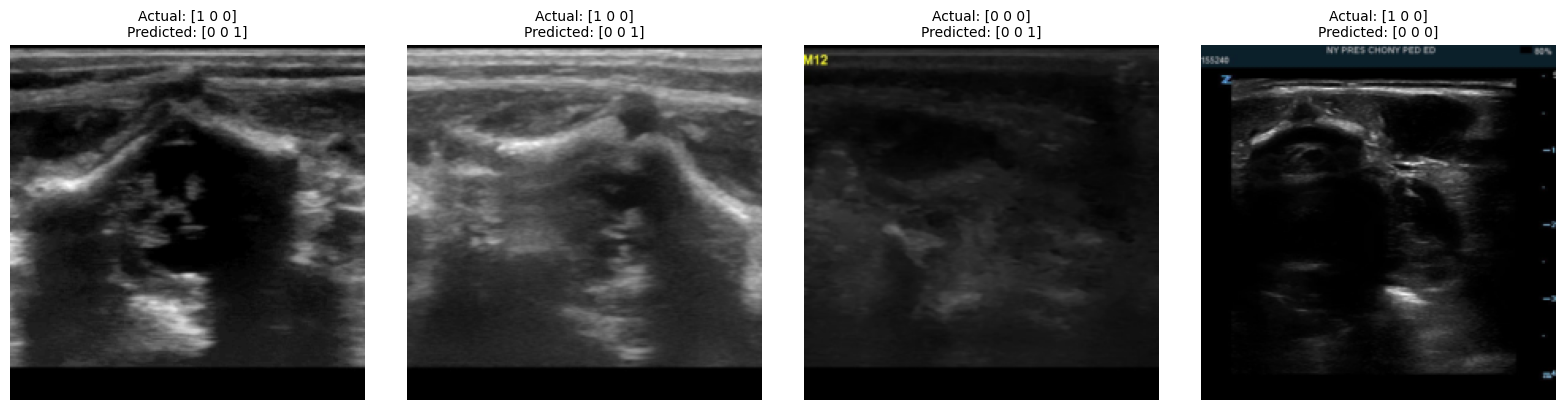

In [ ]:
plot_misclassified_images(test_dataset, binarized_preds, references, num_images=10, id2label=id2label)

In [ ]:
model_name

'Thyroid-Ultrasound-Image-Classification-ViTModel'

In [ ]:
lora_adapter_path = f"./{model_name}-finetuned-lora-usg-adapter-trainer"
trainer.model.save_pretrained(lora_adapter_path, save_adapter=True, save_config=True)

print(f"LoRA adapters saved to: {lora_adapter_path}")

LoRA adapters saved to: ./Thyroid-Ultrasound-Image-Classification-ViTModel-finetuned-lora-usg-adapter-trainer


In [ ]:
# !cp -r /content/deit-base-patch16-224-finetuned-lora-usg-adapter-trainer /content/drive/MyDrive/lora_weights_vit_base_patch_16/

In [ ]:
# !cp -r /content/deit-base-patch16-224-finetuned-lora-usg-new /content/drive/MyDrive/lora_weights_vit_base_patch_16/

In [ ]:
lora_adapter_path = 'Thyroid-Ultrasound-Image-Classification-ViTModel-finetuned-lora-usg-adapter-trainer'

In [ ]:
from transformers import ViTForImageClassification, AutoModelForImageClassification
from peft import PeftModel
import torch

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Paths
# model_checkpoint = "facebook/deit-base-patch16-224"
# lora_adapter_path = 'deit-base-patch16-224-finetuned-lora-usg-adapter-trainer'

# Reload the base model with compatible configurations
base_model1 = ViTForImageClassification.from_pretrained(
    model_checkpoint,
    torch_dtype=torch.float16,
    device_map=None,  # Remove "auto" to avoid conflicts with manual `.to(device)`
    ignore_mismatched_sizes=True,
    num_labels=3,
    label2id=label2id,
    id2label=id2label,
)

# Load the LoRA adapter into the base model
lora_model1 = PeftModel.from_pretrained(
    base_model1,
    lora_adapter_path,
    torch_dtype=torch.float16
)

# Move the model to the correct device
lora_model1.to(device)

print("LoRA model loaded successfully.")


loading configuration file config.json from cache at /home/ab5640/.cache/huggingface/hub/models--agent593--Thyroid-Ultrasound-Image-Classification-ViTModel/snapshots/2cbfdfedab0c1d6ac0fe402a763f5e9c3cd33fce/config.json
Model config ViTConfig {
  "_name_or_path": "google/vit-base-patch16-224-in21k",
  "architectures": [
    "ViTForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "BAD QUALITY",
    "1": "CORD",
    "2": "FLUID"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "BAD QUALITY": 0,
    "CORD": 1,
    "FLUID": 2
  },
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "problem_type": "single_label_classification",
  "qkv_bias": true,
  "torch_dtype": "float32",
  "transformers_version": "4

LoRA model loaded successfully.


In [ ]:
import os
from PIL import Image
import torch
from transformers import AutoFeatureExtractor
import matplotlib.pyplot as plt

# Ensure the model is on the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lora_model1.to(device)
lora_model1.eval()

# Load the image processor (feature extractor)
image_processor = AutoFeatureExtractor.from_pretrained(model_checkpoint)

# Define the transforms used during training
from torchvision.transforms import (
    Compose, Resize, CenterCrop, ToTensor, Normalize
)

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
inference_transforms = Compose([
    Resize(image_processor.size["height"]),
    CenterCrop(image_processor.size["height"]),
    ToTensor(),
    normalize,
])

def load_and_preprocess_image(image_path):
    """
    Load and preprocess a single image.
    """
    image = Image.open(image_path).convert('RGB')
    image = inference_transforms(image).unsqueeze(0)  # Add batch dimension
    return image.to(device)

def predict_image(image_tensor):
    """
    Perform inference on a single preprocessed image tensor.
    """
    with torch.no_grad():
        outputs = lora_model1(pixel_values=image_tensor)
        logits = outputs.logits
        probs = torch.sigmoid(logits)  # For multi-label classification
        return probs.cpu().numpy()

import matplotlib.pyplot as plt
import pandas as pd

def display_predictions_grid(image_paths, predictions, id2label, threshold=0.5, n_cols=5):
    """
    Display images along with predicted labels in a grid.
    """
    n_images = len(image_paths)
    n_rows = (n_images + n_cols - 1) // n_cols  # Calculate the number of rows needed

    plt.figure(figsize=(n_cols * 4, n_rows * 4))

    for i, img_path in enumerate(image_paths):
        # Load and preprocess the image for display
        image = Image.open(img_path)
        pred_labels = [id2label[j] for j, prob in enumerate(predictions[i]) if prob >= threshold]

        # Plot the image
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(image)
        plt.axis('off')
        plt.title(f"Predicted: {', '.join(pred_labels) if pred_labels else 'None'}")

    plt.tight_layout()

# Directory containing new, unlabeled images
unlabeled_images_dir = 'Data Files/PANIDA LP IMAGES'  # Change this path

loading configuration file preprocessor_config.json from cache at /home/ab5640/.cache/huggingface/hub/models--agent593--Thyroid-Ultrasound-Image-Classification-ViTModel/snapshots/2cbfdfedab0c1d6ac0fe402a763f5e9c3cd33fce/preprocessor_config.json
loading configuration file config.json from cache at /home/ab5640/.cache/huggingface/hub/models--agent593--Thyroid-Ultrasound-Image-Classification-ViTModel/snapshots/2cbfdfedab0c1d6ac0fe402a763f5e9c3cd33fce/config.json
Model config ViTConfig {
  "_name_or_path": "agent593/Thyroid-Ultrasound-Image-Classification-ViTModel",
  "architectures": [
    "ViTForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "normal thyroid",
    "1": "malignant",
    "2": "benign"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "benign": 2,
    "malignant": 1,
    "normal th

In [ ]:
def save_predictions_to_csv(image_paths, predictions, id2label, csv_filename='predictions.csv', threshold=0.5):
    """
    Save the predictions in One-Hot Encoded (OHE) format to a CSV file.
    """
    label_columns = list(id2label.values())
    data = []

    for i, img_path in enumerate(image_paths):
        # Extract the predicted labels with the threshold
        ohe_labels = [1 if prob >= threshold else 0 for prob in predictions[i]]
        row = {'filename': os.path.basename(img_path)}
        row.update({label: ohe for label, ohe in zip(label_columns, ohe_labels)})
        data.append(row)

    # Convert to DataFrame and save as CSV
    df = pd.DataFrame(data)
    df.to_csv(csv_filename, index=False)
    print(f"Predictions saved to {csv_filename}")

In [ ]:
from PIL import Image
Image.MAX_IMAGE_PIXELS = None

Predictions saved to predictions.csv


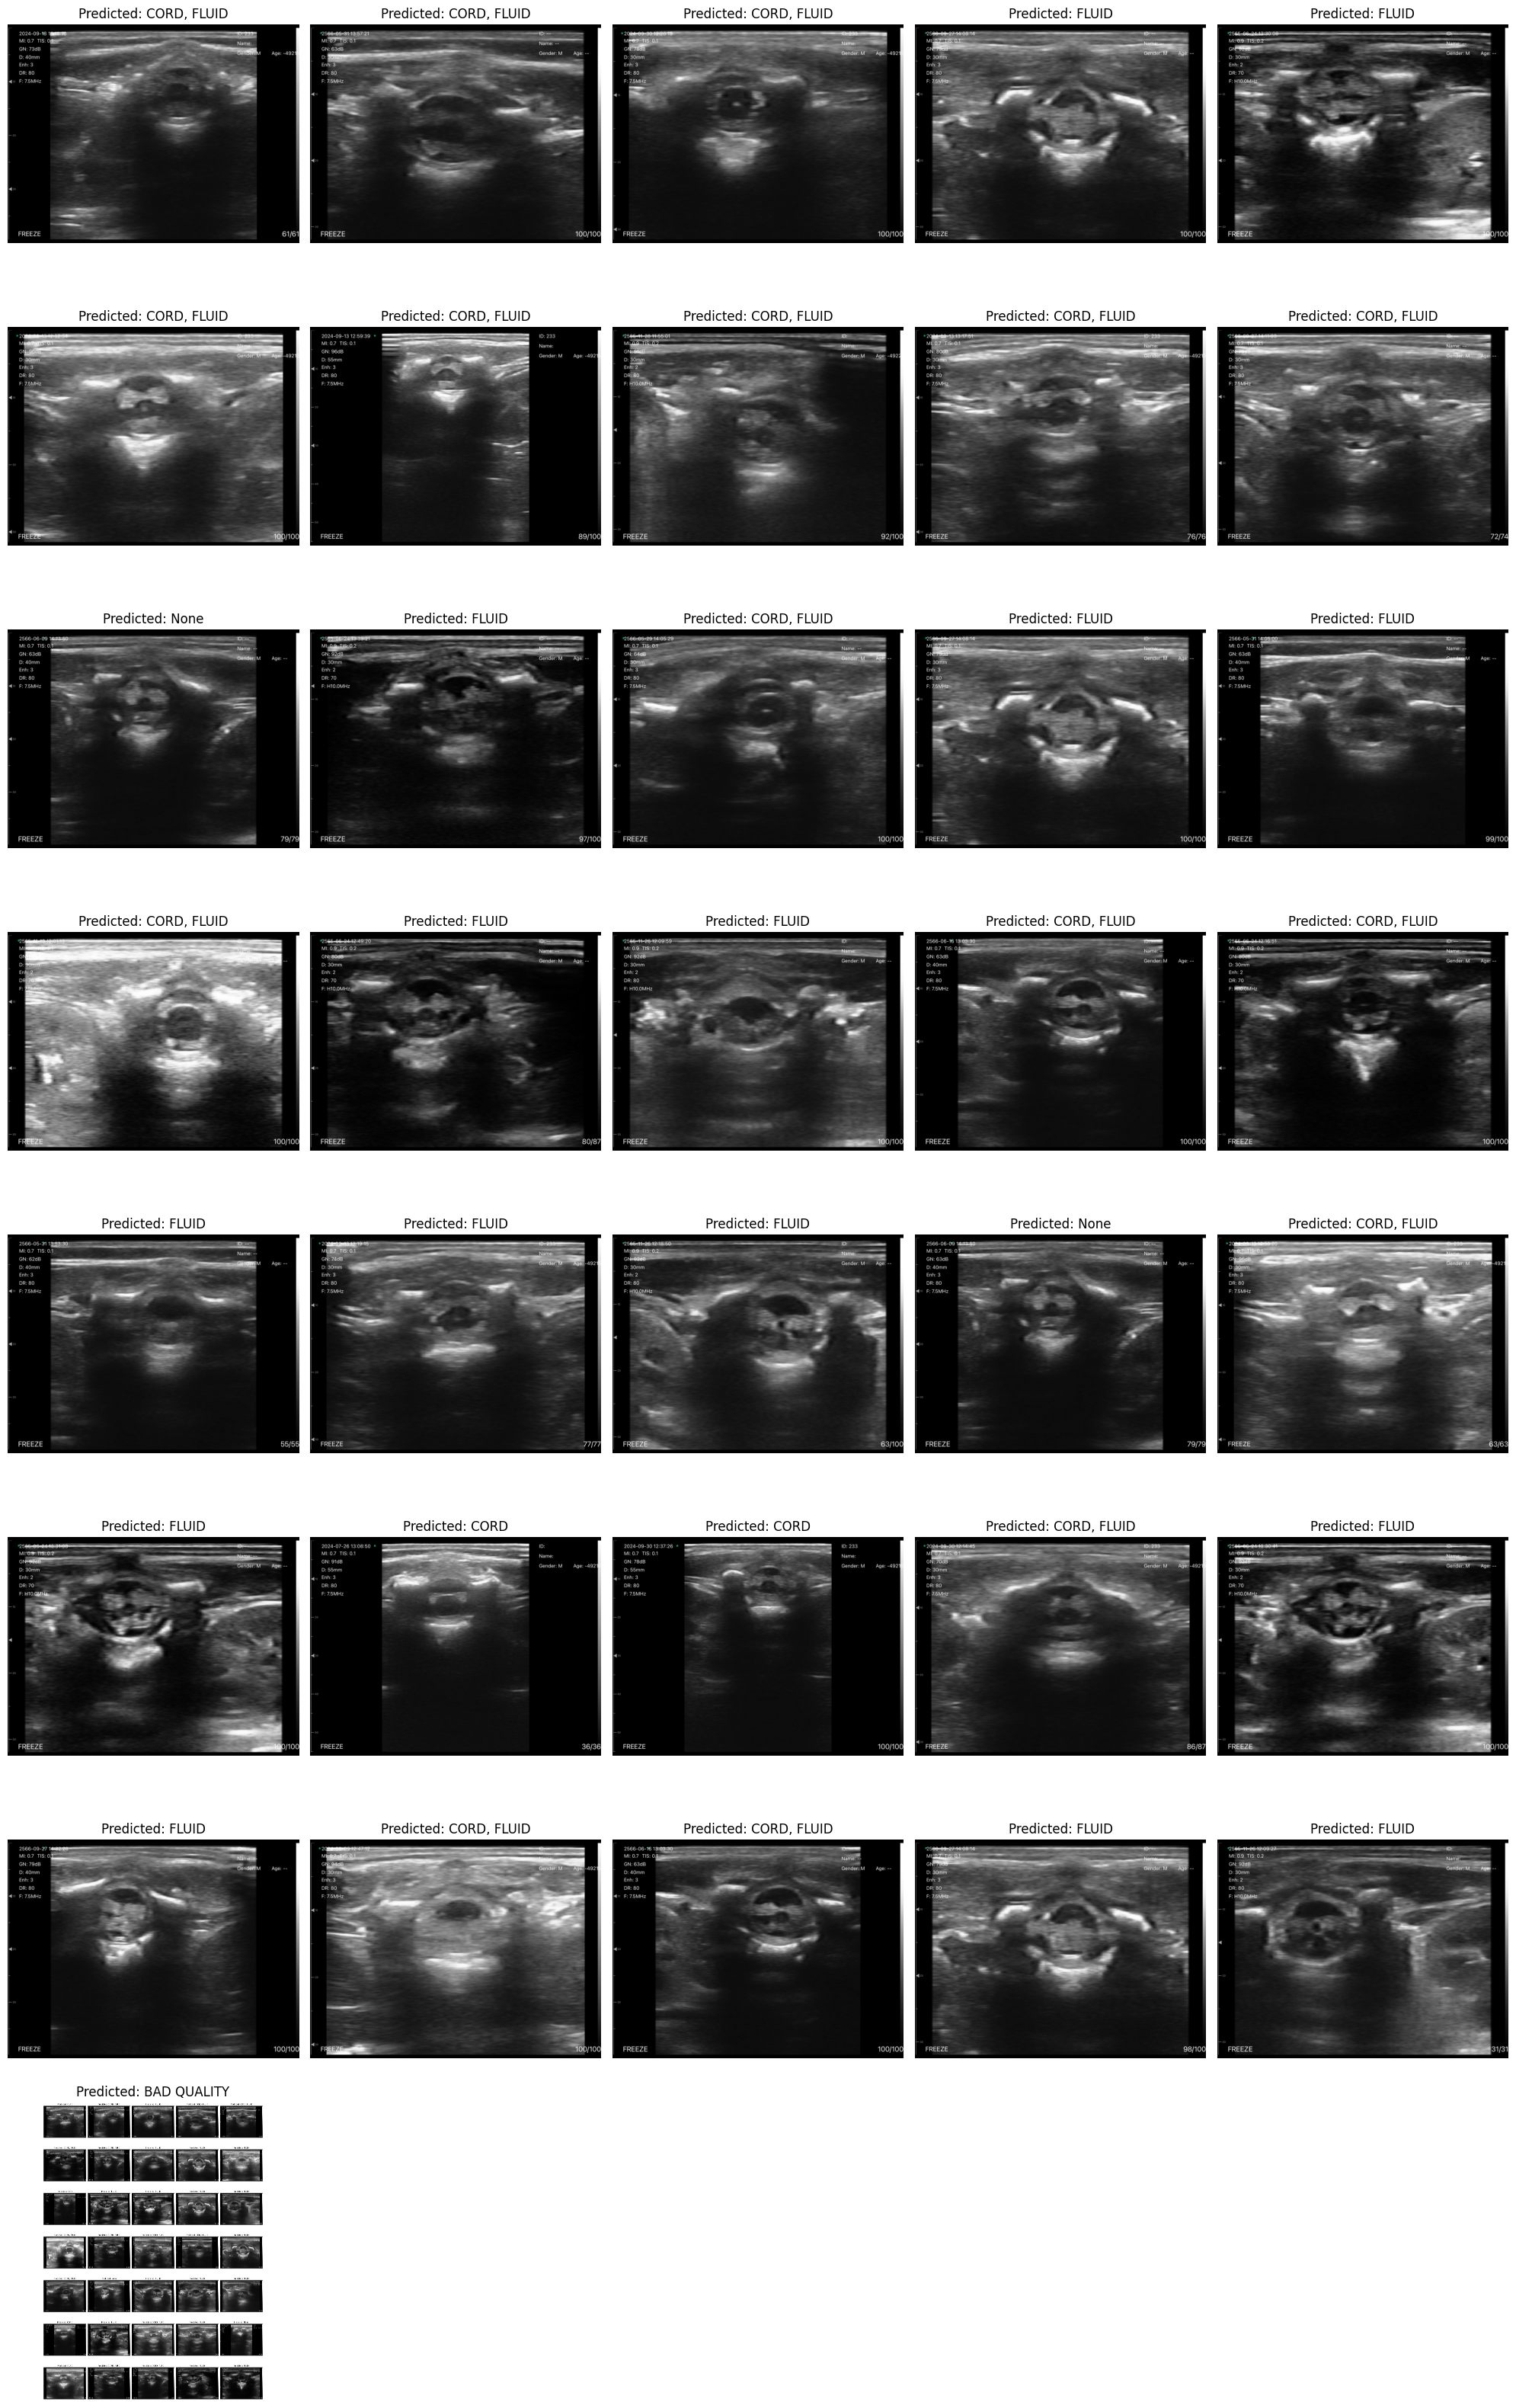

In [ ]:
unlabeled_images_dir = 'Data Files/PANIDA LP IMAGES'  # Change this to your directory
image_paths = [os.path.join(unlabeled_images_dir, f) for f in os.listdir(unlabeled_images_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

predictions_list = []

# Perform inference on all images in the directory
for img_path in image_paths:
    # Load and preprocess the image
    img_tensor = load_and_preprocess_image(img_path)

    # Predict the labels
    predictions = predict_image(img_tensor)
    predictions_list.append(predictions)

# Convert predictions list to numpy array for easier processing
predictions_array = np.vstack(predictions_list)

# Display the predictions in a grid
display_predictions_grid(image_paths, predictions_array, id2label, threshold=0.5, n_cols=5)

# Save the predictions in OHE format to a CSV
save_predictions_to_csv(image_paths, predictions_array, id2label, csv_filename='predictions.csv', threshold=0.5)

In [ ]:
# !cp /content/predictions.csv '/content/drive/MyDrive/PANIDA LP IMAGES/'

In [ ]:
# !cp /content/predictions.jpg '/content/drive/MyDrive/PANIDA LP IMAGES/'